# Embeddings and BPE Tokenization
* Notebook by Adam Lang
* Date: 2/14/2025

# Overview
* This notebook is sampled from the
Supplementary code for the Build a Large Language Model From Scratch book by Sebastian Raschka

* Code repository: https://github.com/rasbt/LLMs-from-scratch

* This notebook also contains material from Analytics Vidhya course "Mastering Multimodal RAG & Embeddings with Amazon Nova & Bedrock".
* The purpose is to go into the technical building blocks of BPE tokenization with LLMs before building a multimodal RAG pipeline or application.

In [7]:
%%capture
!pip install tiktoken

In [8]:
from importlib.metadata import version
import tiktoken
import torch

## version
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.5.1+cu124
tiktoken version: 0.9.0


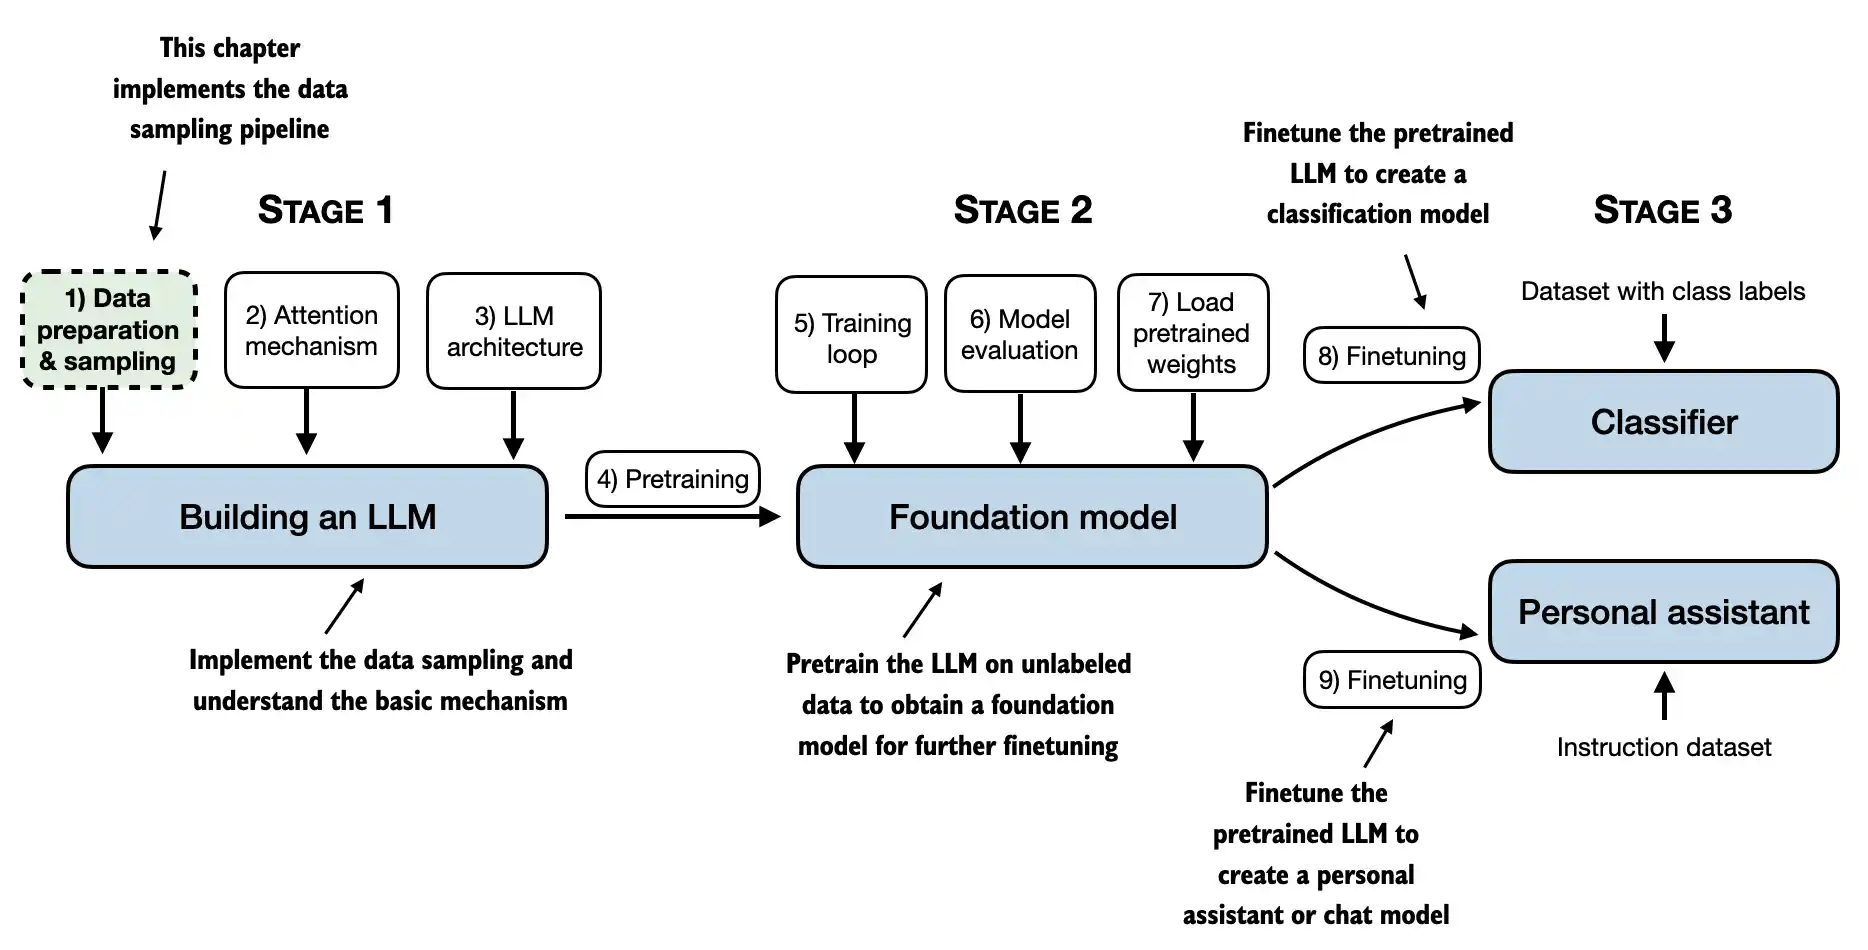

Summary
* The purpose is to understand how the data is prepared before you send it to an LLM whether it be TEXT or MULTIMODAL

# Understanding Word Embeddings
* The concept regardless of the use case is that we need to take **unlabeled input data** and create semantic vector representations also known as embeddings, so how do we do that?

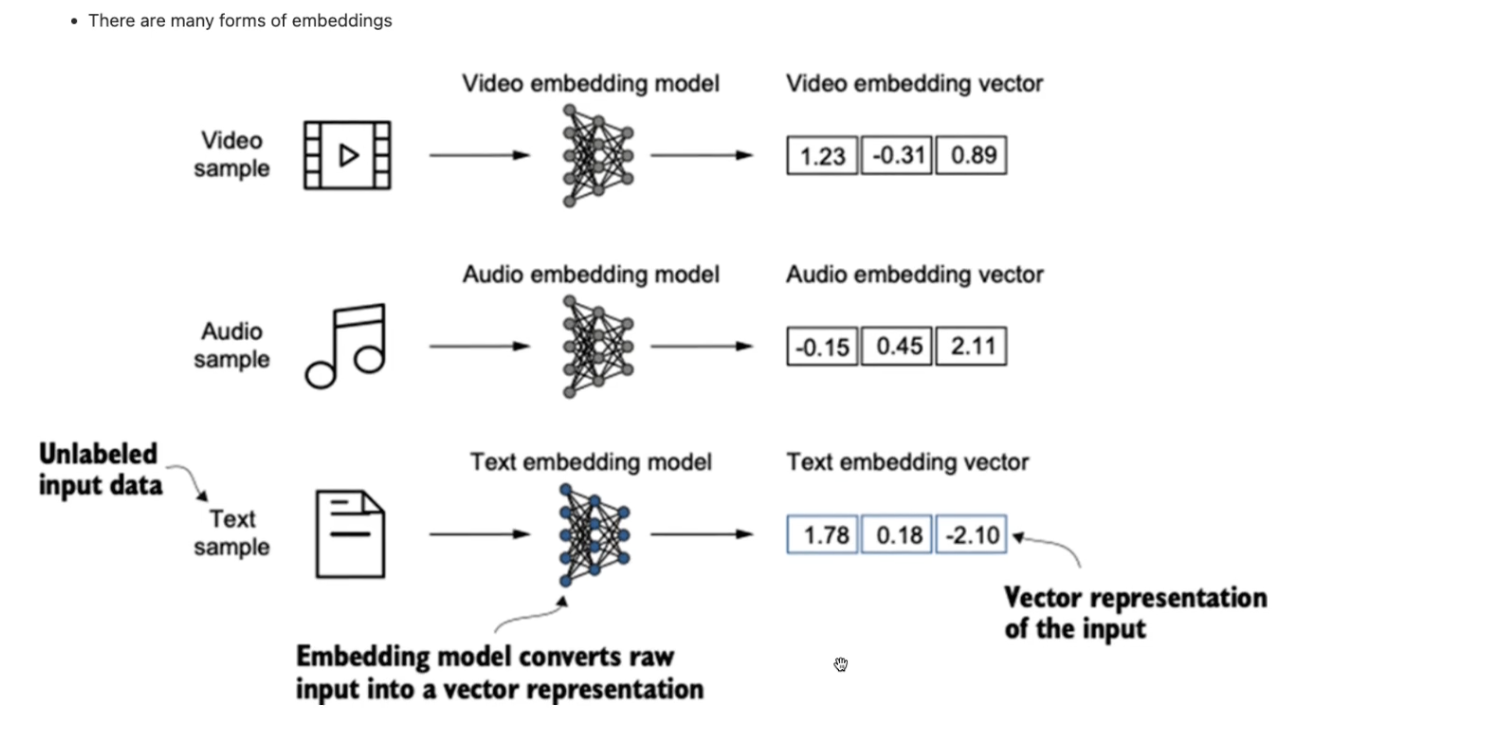

# Tokenizing Text
* This is always the first step for any type of LLM.
* Image from Sebastian Raschka's course:

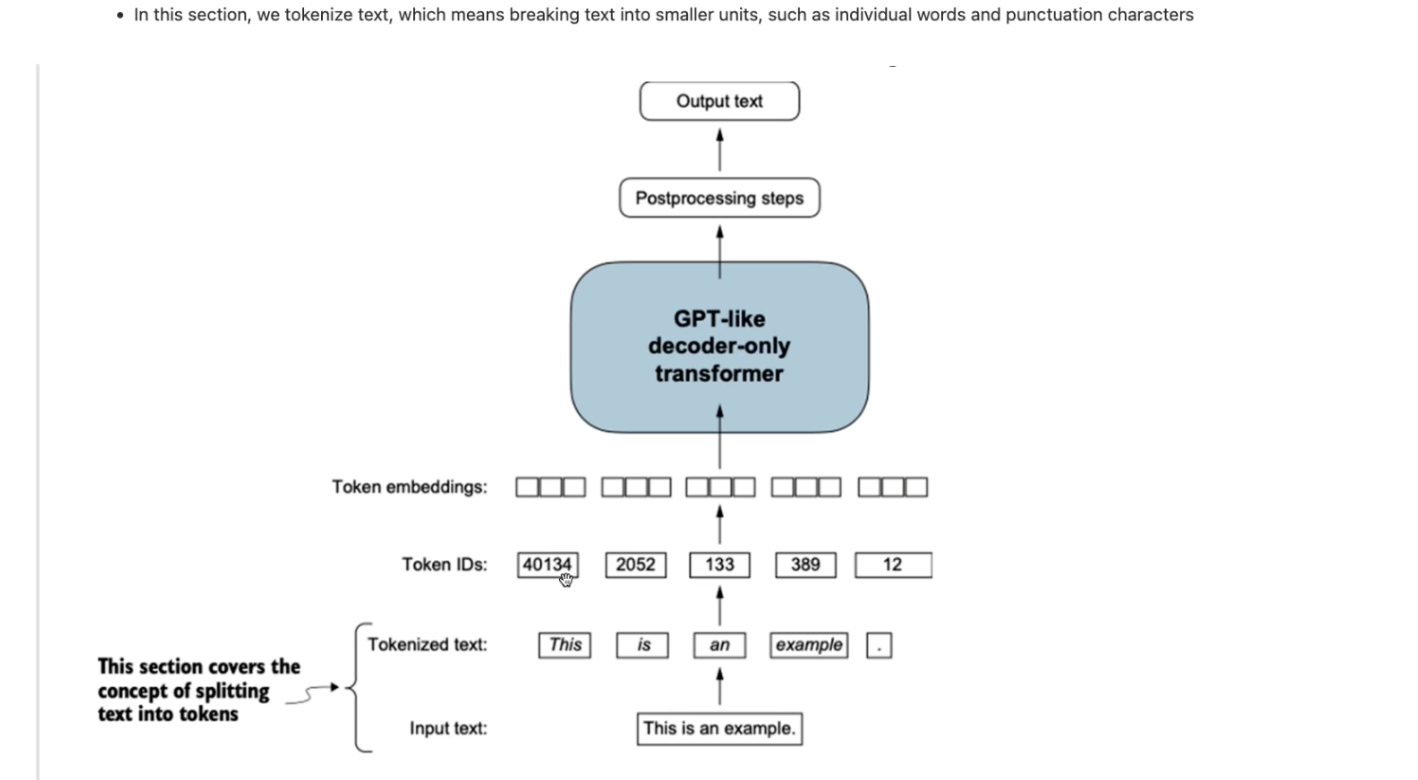

Summary
* Lets say we have input data/text of 100,000 words, the token ID is labeled numerically.
* So above we see:
  * 40134 --> this is 40,134, etc..
* Every token ID has a token embedding array or tensor.

## Load Dataset
* This is the short story called "The Verdict" by Edith Wharton.
* Publicly available here: https://www.eastoftheweb.com/short-stories/UBooks/Verd.shtml

In [9]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
## open the short story txt file
story_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning Notebooks/the-verdict.txt'
with open(story_path, "r", encoding='utf-8') as f:
  raw_text = f.read()

print("Total number of characters in text:", len(raw_text))
print(raw_text[:50])

Total number of characters in text: 20479
I HAD always thought Jack Gisburn rather a cheap g


Summary:
* Our goal is to tokenize and embed the text for an LLM to take as input.
* We will build a simple tokenizer based on simple sample text that we can then apply later to the sample text.


### 1. Tokenizer below uses regular expressons split on white spaces

In [11]:
import re

text = "Hello world. This, is a test."
## split reg expressions on white space
result = re.split(r'(\s)', text)

print(result)

['Hello', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


### 2. Tokenizer split on special characters

In [12]:
text= "Hello, world. Is this -- a test? Hello!"

## special characters
result = re.split(r'([,.:;?_!"()\']--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello,', 'world.', 'Is', 'this', '--', 'a', 'test?', 'Hello!']


Should you remove whitespaces -- yay or nay?
* The app you are building really depends on whether or not to encode white spaces as separate characters or simply remove them.
* **If you remove whitespaces you reduce the memory and computing requirements.**
* If you keep whitespaces it can be very useful if you train LLMs that are sensitive to **specific/extact structure of text**.
  * As an example: Python code which is very sensitive to spacing and indentation!
* As we saw above we removed the whitespaces for simplicity and to shorten the tokenized outputs.

## Applying Special Character Tokenizer to Text file
* We can now apply this to the short story we loaded.

In [13]:
## tokenize raw text file
preprocessed_text = re.split(r'([,.:;?_!"()\']--|\s)', raw_text)
preprocessed_text = [item.strip() for item in preprocessed_text if item.strip()]

## print the first 30 tokens
print(preprocessed_text[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius--though', 'a', 'good', 'fellow', 'enough--so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that,', 'in', 'the', 'height', 'of', 'his', 'glory,']


In [14]:
## get total tokens
print(len(preprocessed_text))

3646


## Convert Tokens into Token IDs
* We need token IDs to process via embedding layers later on.
* **The text has duplicate tokens, thus we need to sort the text to get the unique tokens.**

In [15]:
## find unique words/tokens in the "vocabulary"
all_words = sorted(set(preprocessed_text))
vocab_size = len(all_words)

## print out total vocabulary size
print(vocab_size)

1486


In [16]:
## now we assign a unique ID number to each token using dict comprehension
vocab = {token:integer for integer, token in enumerate(all_words)}

Now we can see the first 100 entries in the vocab:

In [17]:
for i, item in enumerate(vocab.items()):
  print(item)
  if i == 100:
    break

('!--', 0)
('"--', 1)
('"Ah,', 2)
('"Ah--I', 3)
('"Be', 4)
('"By', 5)
('"Come', 6)
('"Destroyed', 7)
('"Don\'t', 8)
('"Gisburns"', 9)
('"Grindles."', 10)
('"Hang', 11)
('"Has', 12)
('"How', 13)
('"I', 14)
('"I\'d', 15)
('"If', 16)
('"It', 17)
('"It\'s', 18)
('"Jack', 19)
('"Money\'s', 20)
('"Moon-dancers"', 21)
('"Mr.', 22)
('"Mrs.', 23)
('"My', 24)
('"Never', 25)
('"Never,"', 26)
('"Of', 27)
('"Oh,', 28)
('"Once,', 29)
('"Only', 30)
('"Or', 31)
('"That', 32)
('"The', 33)
('"Then', 34)
('"There', 35)
('"There:', 36)
('"This', 37)
('"We', 38)
('"Well,', 39)
('"What', 40)
('"When', 41)
('"Why', 42)
('"Yes,', 43)
('"Yes--quite', 44)
('"Yes--she\'s', 45)
('"You', 46)
('"deadening', 47)
('"dragged', 48)
('"effects";', 49)
('"interesting":', 50)
('"lift', 51)
('"obituary"', 52)
('"strongest,"', 53)
('"strongly"', 54)
('"sweetly', 55)
("'Are", 56)
("'It's", 57)
("'coming'", 58)
("'done'", 59)
("'subject.'", 60)
("'technique'", 61)
("'way", 62)
('(I', 63)
('(Though', 64)
('.', 65)
('."', 66)
(

# Build a "Simple" Tokenizer using all steps above


In [18]:
class SimpleTokenizerV1:
  def __init__(self, vocab):
    self.str_to_int = vocab
    self.int_to_str = {i:s for s,i in vocab.items()}

  ## 1. encode text
  def encode(self, text):
    ## tokenize raw text file
    preprocessed = re.split(r'([,.:;?_!"()\']--|\s)', text)
    preprocessed = [
        item.strip() for item in preprocessed if item.strip()
                  ]
    ## token to ids
    ids = [self.str_to_int[s] for s in preprocessed]
    return ids

  ## 2. decode text --> given token id looks up and decodes token
  def decode(self, ids):
    text = " ".join([self.int_to_str[i] for i in ids])
    # Replace spaces before the specified punctuations
    text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
    return text


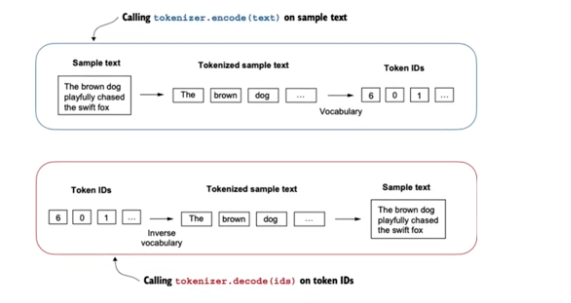

In [19]:
## init tokenizer
tokenizer = SimpleTokenizerV1(vocab)

text = """It is the last he painted, you know,
          Mrs. Gisburn said with pardonable pride."""

## get ids
ids = tokenizer.encode(text)
print(ids)

[118, 773, 1292, 810, 691, 1005, 1478, 800, 133, 93, 1133, 1451, 1020, 1071]


Summary
* We now have the token ids.


We can decode them now.

In [20]:
tokenizer.decode(ids)

'It is the last he painted, you know, Mrs. Gisburn said with pardonable pride.'

Summary
* This works pretty well, we can encode and decode the text.

### Key error example

In [21]:
text = "Hello, do you like tea. Is this-- a test?"

tokenizer.encode(text)

KeyError: 'Hello,'

Summary
* It seems that "Hello" is not in the vocabulary! Thus there is no id for it.
* In the real world this is VERY COMMON. An LLM is trained on a specific corpus. However when it goes to production and performs inference on text or data it HAS NOT been trained on, there is no id which is why you get errors or hallucinations.


# How can we handle out of vocabulary tokens -- Answer: Special Tokens!
* Special tokens are always a part of LLMs and embedding models for "unkown words" and to also note the end of text.

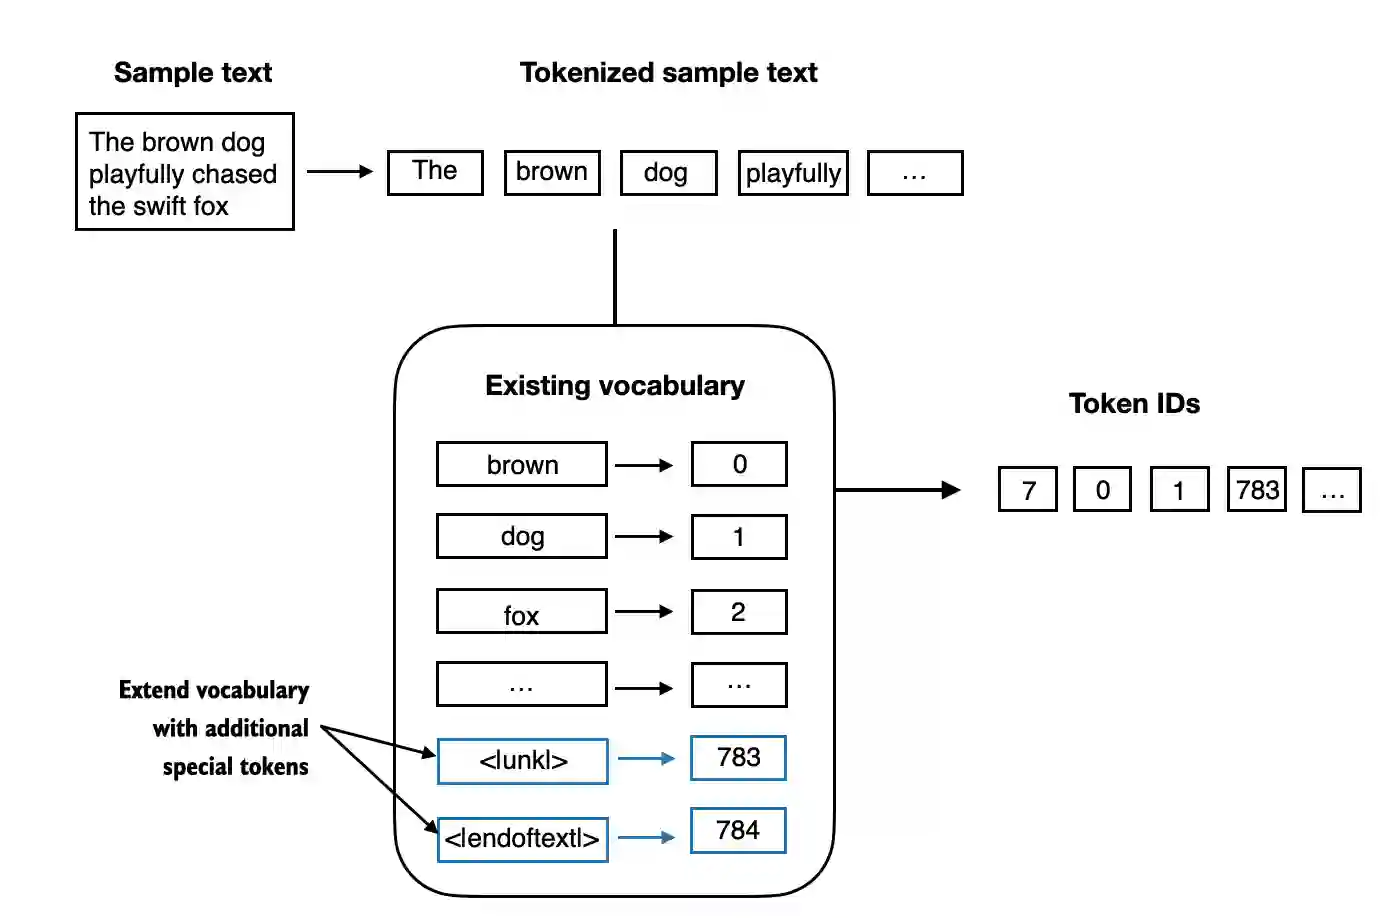

* Some tokenizers use special tokens to help the LLM with additional context

* Some of these special tokens are

  * `[BOS]` (beginning of sequence) marks the beginning of text
  * `[EOS]` (end of sequence) marks where the text ends (this is usually used to concatenate multiple unrelated texts, e.g., two different Wikipedia articles or two different books, and so on)
  * `[PAD]` (padding) if we train LLMs with a batch size greater than 1 (we may include multiple texts with different lengths; with the padding token we pad the shorter texts to the longest length so that all texts have an equal length)
  * `[UNK]` to represent words that are not included in the vocabulary

* Note that GPT-2 does not need any of these tokens mentioned above but only uses an `<|endoftext|>` token to reduce complexity

* The `<|endoftext|>` is analogous to the `[EOS]` token mentioned above

* GPT also uses the `<|endoftext|>` for padding (since we typically use a mask when training on batched inputs, we would not attend padded tokens anyways, so it does not matter what these tokens are)

* GPT-2 does not use an `<UNK>` token for out-of-vocabulary words; instead, GPT-2 uses a byte-pair encoding (BPE) tokenizer, which breaks down words into subword units which we will discuss in a later section

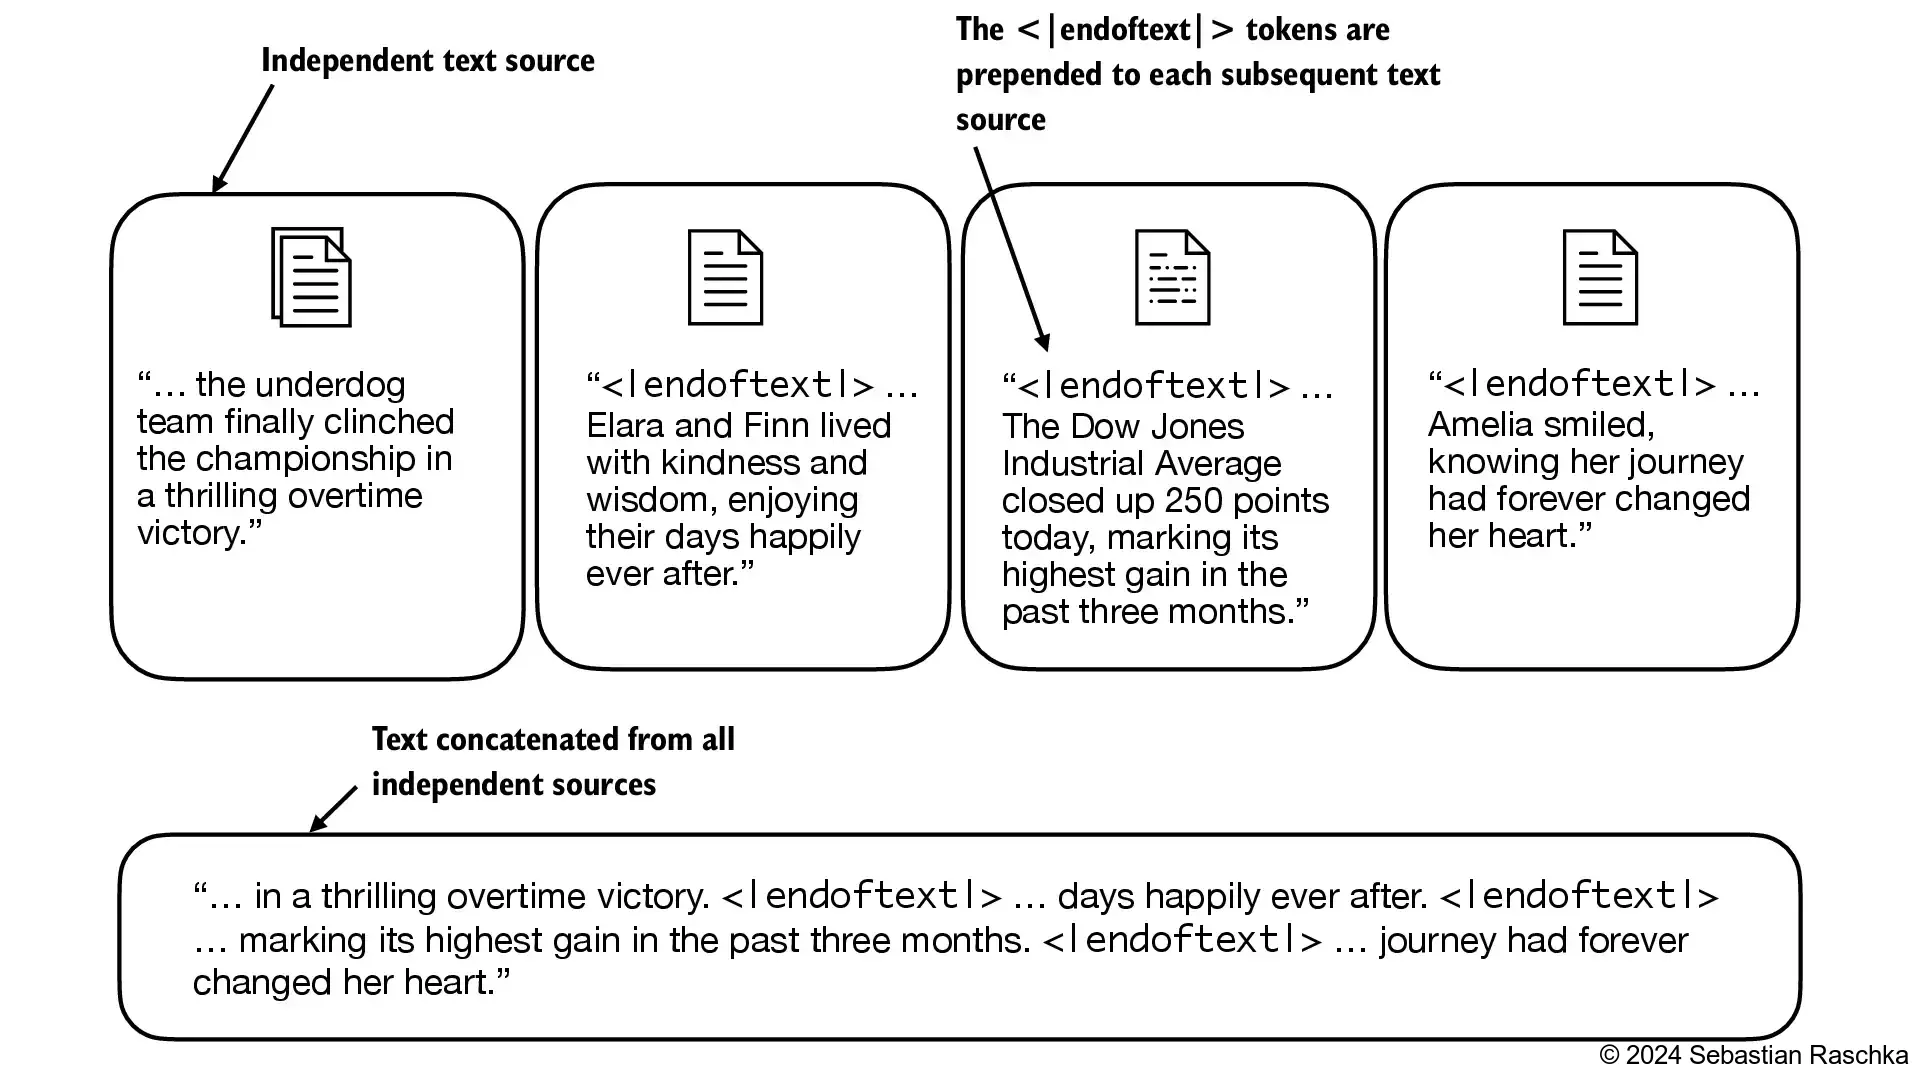

Summary
* The purpose of above is that you can add special tokens such as `<|endoftext|>` at the end of each file to tell the LLM when each file starts and begins. This could be very helpful in RAG and model fine tuning.

In [22]:
## lets review vocab size
len(vocab)

1486

In [23]:
## sampe preprocessing and creating vocab as above
preprocessed = re.split(r'([,.:;?_!"()\']--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]

all_tokens = sorted(list(set(preprocessed)))

## adding 2 extra tokens
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

## create new vocab
vocab = {token:integer for integer, token in enumerate(all_tokens)}

In [24]:
## len of tokens
len(all_tokens)

1488

In [25]:
## now we can look at last 5 tokens
for i, item in enumerate(list(vocab.items())[-5:]):
  print(item)

('younger', 1483)
('your', 1484)
('yourself', 1485)
('<|endoftext|>', 1486)
('<|unk|>', 1487)


## Update Simple Tokenizer
* Nowe we can add the new tokens.

In [26]:
class SimpleTokenizerV2:
  def __init__(self, vocab):
    self.str_to_int = vocab
    self.int_to_str = {i:s for s,i in vocab.items()}

  ## 1. encode text
  def encode(self, text):
    ## tokenize raw text file
    preprocessed = re.split(r'([,.:;?_!"()\']--|\s)', text)
    preprocessed = [item.strip() for item in preprocessed if item.strip()]
    ## checks if token exists --> else token is "unk"
    preprocessed = [
                      item if item in self.str_to_int
                      else "<|unk|>" for item in preprocessed
                   ]


    ## token to ids
    ids = [self.str_to_int[s] for s in preprocessed]
    return ids

  ## 2. decode text --> given token id looks up and decodes token
  def decode(self, ids):
    text = " ".join([self.int_to_str[i] for i in ids])
    # Replace spaces before the specified punctuations
    text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
    return text


In [27]:
## testing out updated tokenizer
tokenizer = SimpleTokenizerV2(vocab)

## test text
text1 = "Hello, do you like black coffee?"
text2 = "In the mountains of Colorado is Vail."

## join text1 to text2 with endoftext token
text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like black coffee? <|endoftext|> In the mountains of Colorado is Vail.


In [28]:
## encode text
tokenizer.encode(text)

[1487, 489, 1478, 843, 1487, 1487, 1486, 117, 1292, 1487, 965, 1487, 773, 1487]

In [29]:
## decode text
tokenizer.decode(tokenizer.encode(text))

'<|unk|> do you like <|unk|> <|unk|> <|endoftext|> In the <|unk|> of <|unk|> is <|unk|>'

Summary
* The downside of this technique is that we can see that the "unk" token was used multiple times for the words or terms that were not in the original text.
* GPT does not need any of thes tokens above but only uses the `<|endoftext|>` token to reduce complexity.
* The `<|endoftext|>` is analogous to the `[EOS]` end of sentence token above.
* GPT does not use an `<UNK>` token for out of vocabulary words. Instead, GPT uses byte pair encoding (BPE) tokenizer to break words into sub units.

# BytePair Encoding
* GPT-2 used BytePair encoding (BPE) as its tokenizer
* It allows the model to break down words that aren't in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words
For instance, if GPT-2's vocabulary doesn't have the word "unfamiliarword," it might tokenize it as ["unfam", "iliar", "word"] or some other subword breakdown, depending on its trained BPE merges
* The original BPE tokenizer can be found [here](https://github.com/openai/gpt-2/blob/master/src/encoder.py)
* Since implementing BPE can be pretty complicated, we will use the open source tiktoken which implements BPE algorithm in Rust.

## How BPE Works
* After every word in the vocabulary, a token is added as a word boundary: `</w>`
* Objective of BPE: Find the MOST frequently occuring byte-pair!
* Steps:

1. Count word frequencies first.
2. Count character frequencies from table.
  * Each token occurence is counted.

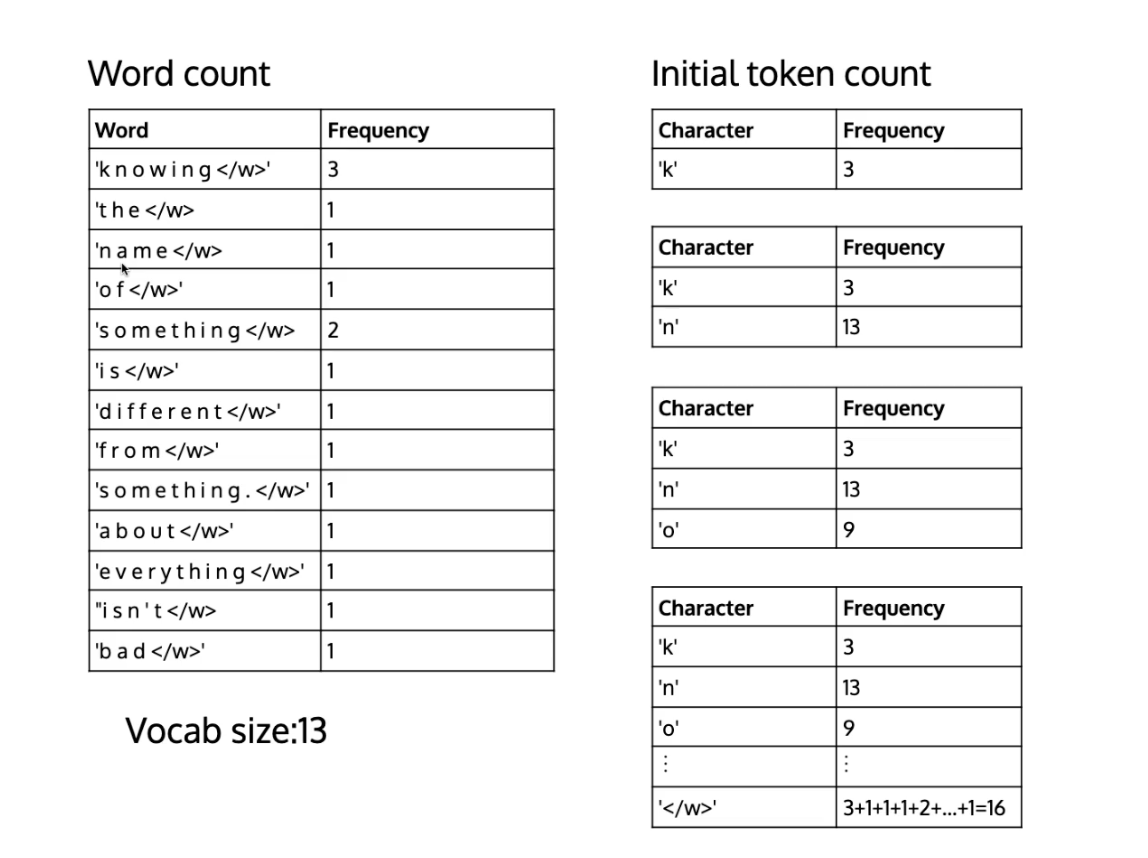




Summary
* So far we know that **Word tokenization** alone is not good.
* We also know that **Character tokenization** alone is not good.
* This is where the 3rd step comes in which basically merges the 2 previous steps: "Byte-Pair Counting"

### Step 3 --> Byte-Pair Counting and Merging
* Count pairs of characters
* The most frequent occuring pair is then "merged".
* As we can see below, "in" is the most frequent occuring byte pair:

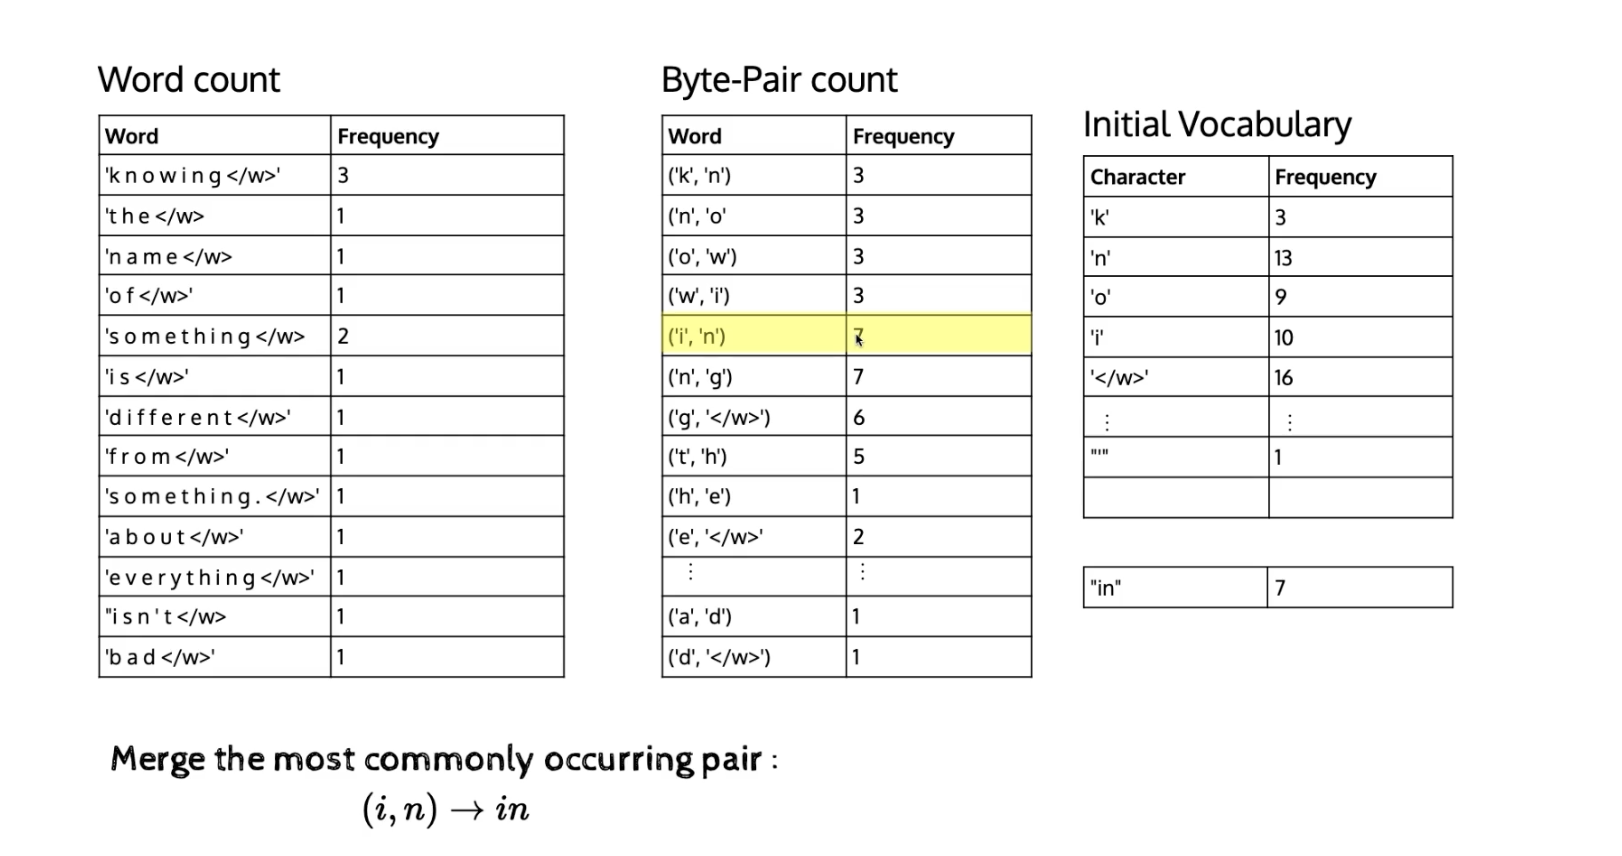


### Step 4 - Update most frequent pairs
* We can see that we get: `in`, `ing`.
* The most frequent occuring byte pair is `ing`.

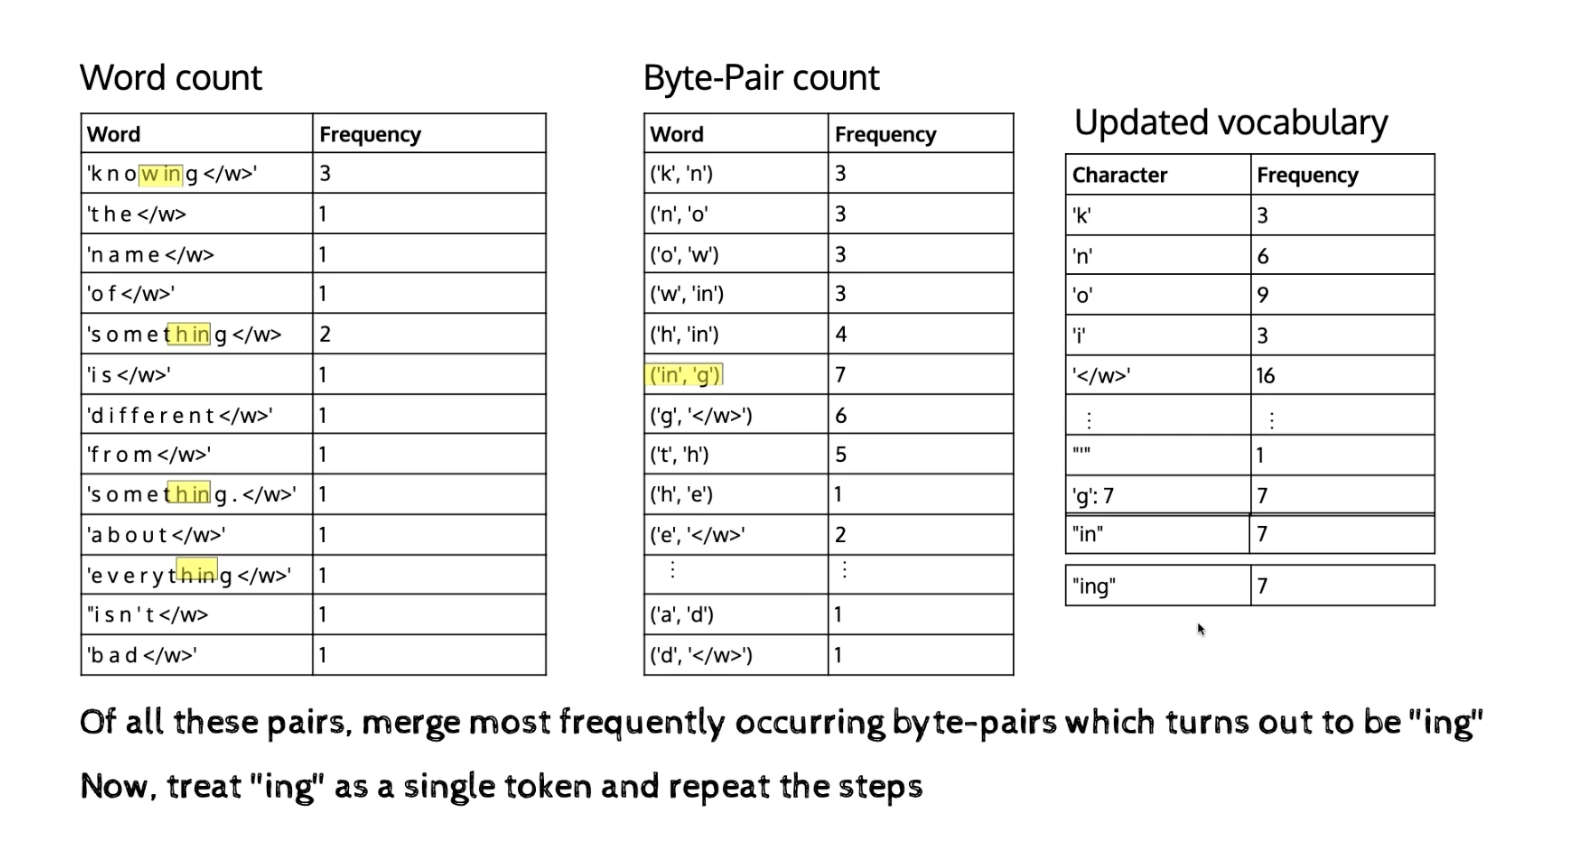

### Step 5 - Final Merge Count
* If you do 45 merges you get 45 byte pairs.
* You then add this to the original vocabulary. If the original vocabulary was 20 then it is 45 + 20 --> 65 which is the final vocabulary size.

# Byte-Pair Encoding -- Implementation with Tiktoken
* We can use the `GPT-2` tokenizer.

In [30]:
import tiktoken
print("tiktoken version:", tiktoken.__version__)

tiktoken version: 0.9.0


In [31]:
## init the GPT-2 tokenizer
tokenizer = tiktoken.get_encoding("gpt2")
tokenizer

<Encoding 'gpt2'>

In [32]:
## get size of gpt2 tokenizer
tokenizer.n_vocab

50257

We can see the various BPE tokenizers available by using the `list_encoding_names` function

In [33]:
tiktoken.list_encoding_names()

['gpt2', 'r50k_base', 'p50k_base', 'p50k_edit', 'cl100k_base', 'o200k_base']

In [34]:
## lets see the vocab size of some of these
tiktoken.get_encoding("o200k_base").n_vocab

200019

## Testing the BPE tokenizer

In [35]:
## test text
text = (
          "Hello, do you like coffee? <|endoftext|> In the sunlit terraces"
          "of someunknownword."
)
## encode test text
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

print(integers)

[15496, 11, 466, 345, 588, 6891, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 4775, 13]


In [37]:
len(text)

82

In [36]:
## decode test text
strings = tokenizer.decode(integers)

print(strings)

Hello, do you like coffee? <|endoftext|> In the sunlit terracesof someunknownword.


Summary
* **What we can see is that the BPE tokenizer is able to break down the unknown words into subwords and individual characters and decode the text.**
  * The word we used above "someunknownword" is a collection of other tokens that the BPE tokenizer is able to probabilistically piece together.

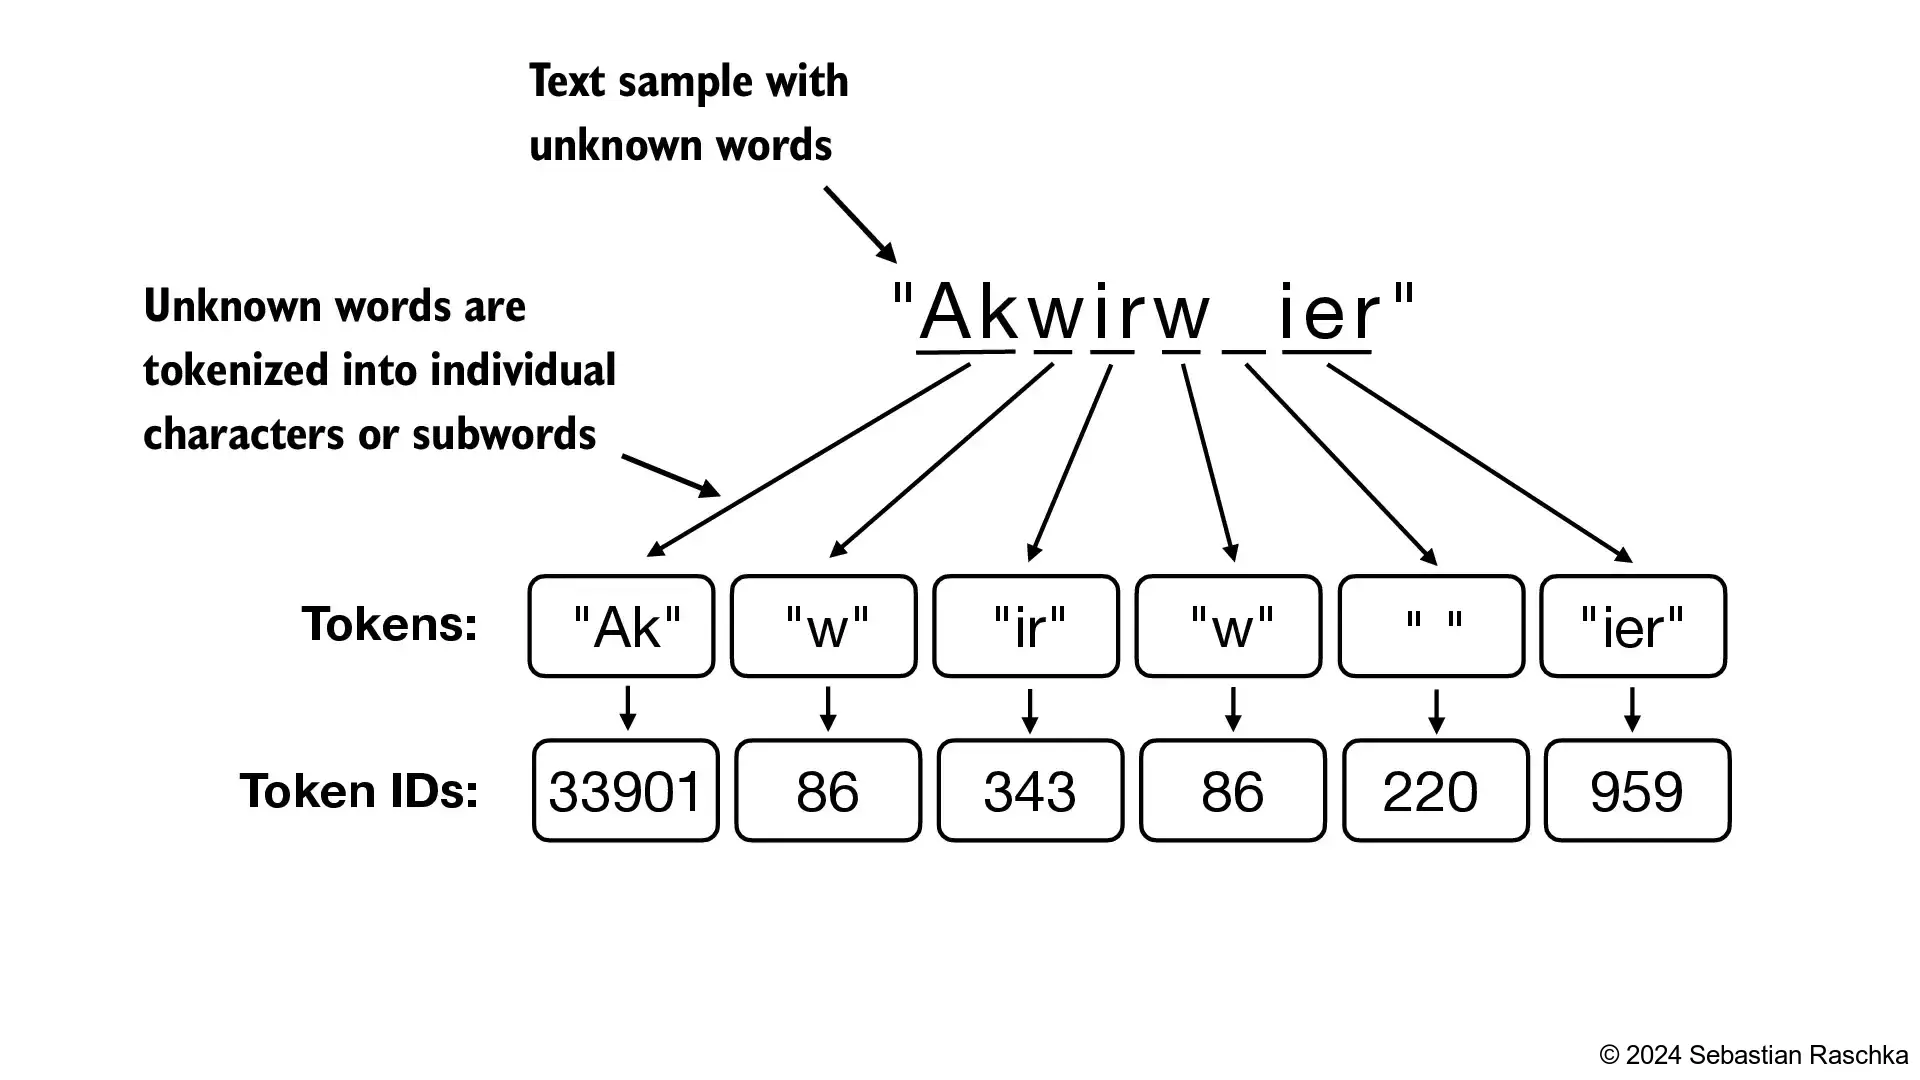

## BPE handling unknown words
* Essentially you can show it ANY word and it should be able to handle it to a certain degree.

In [38]:
## example of unknown word from above
tokenizer.encode("Akwirw ier")

[33901, 86, 343, 86, 220, 959]

In [39]:
## decode the unknown word
tokenizer.decode([33901, 86, 343, 86, 220, 959])

'Akwirw ier'

Summary
* As long as we have the token IDs we can encode and decode the word!